In [1]:
import importlib
import time
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [6]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)

# eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
#     dimension, dx, rho0, covariance.fft_exp_1d,
#     return_Corr=True,
#     return_sort_ind=True)

eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

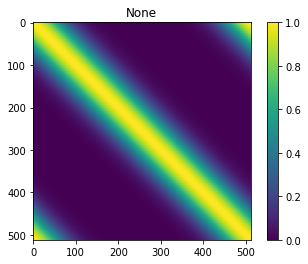

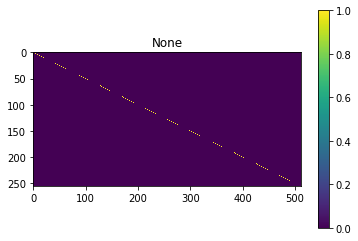

In [7]:
imshow(P, vmin=0)
imshow(H)

0.5000000000000001
1.0


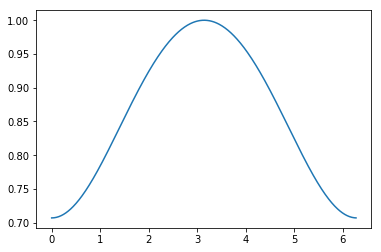

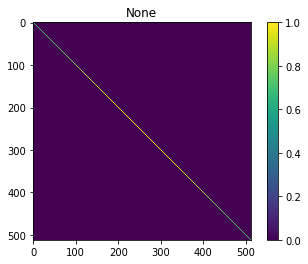

In [12]:
x = np.arange(dimension, dtype=float)*(2 * np.pi)/dimension
A = 0.5
D = np.diag(np.sqrt(-0.5 * A * (np.cos(x) + 1) + 1))
print((D.diagonal()**2).min())
print((D.diagonal()**2).max())
plt.figure()
plt.plot(x, D.diagonal())
imshow(D)

In [13]:
P = D @ P @ D

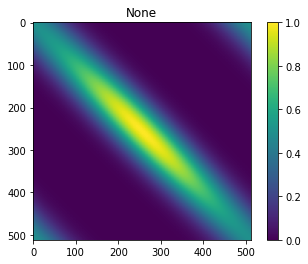

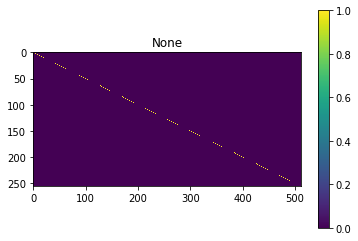

In [14]:
imshow(P, vmin=0)
imshow(H)

In [15]:
trans_mats = assimilate.transformation_matrices(
    H, P=P,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


In [16]:
def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return dist


def angle_2(V0, V1):
    norm0 = sp.linalg.norm(V0, ord=2, axis=0)
    norm1 = sp.linalg.norm(V1, ord=2, axis=0)
    V0 = V0/norm0
    V1 = V1/norm1
    IPs = V0.T @ V1
    sigmas = sp.linalg.svd(
        IPs,
        compute_uv=False)
    dist = np.arccos(sigmas)
    dist = dist.mean()
    return dist

In [17]:
def resample(ensemble, resample_size=None):
    if resample_size is None:
        resample_size = ensemble.shape[1]
    max_int = ensemble.shape[1]
    random_indexes = np.random.randint(0, max_int, resample_size)
    
    return ensemble[:, random_indexes]

# With one master vector

In [18]:
ens_size = 60
mu = np.zeros(dimension)
ensemble = (
    assimilate.generate_ensemble(
        ens_size, mu, trans_mats['P_sqrt']))
P_sample = np.cov(ensemble)

In [20]:
ens_size = 60
ens_ens_size = 10
resample_size = None
mu = np.zeros(dimension)
ensemble = (
    assimilate.generate_ensemble(
        ens_size, mu, trans_mats['P_sqrt']))
P_sample = np.cov(ensemble)
P_sample_array = np.ones([dimension, dimension, ens_ens_size])
for ens_ens_num in range(ens_ens_size):
    temp_ens = resample(ensemble=ensemble,
                        resample_size=resample_size)
    P_sample_array[:, :, ens_ens_num] = np.cov(temp_ens)

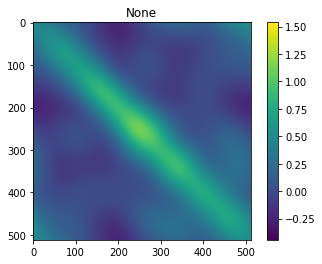

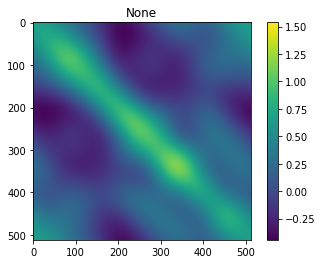

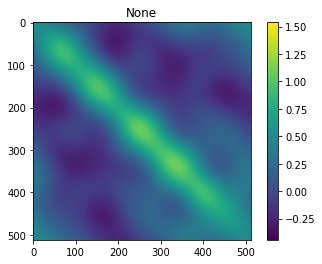

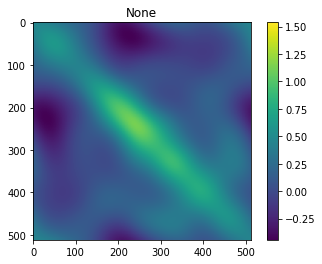

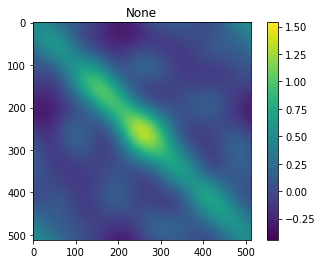

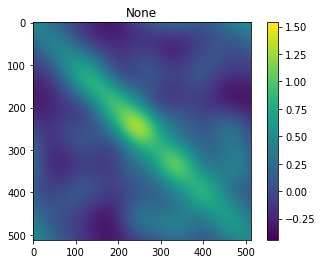

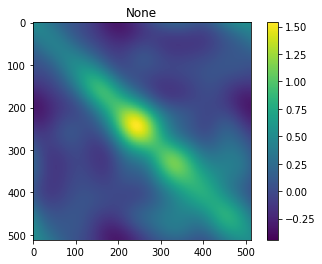

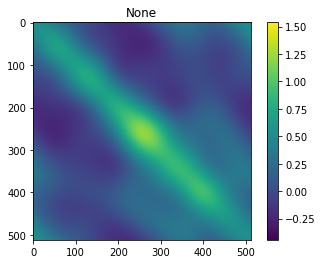

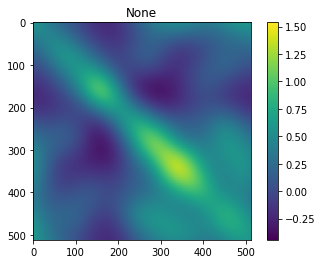

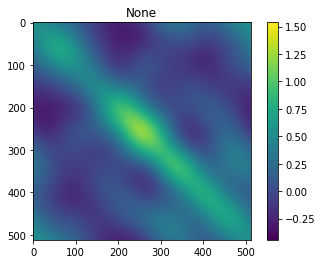

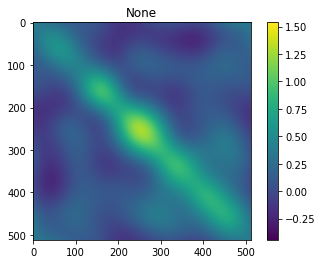

In [22]:
vmin = np.min([P_sample.min(),
               P_sample_array.min()])
vmax = np.max([P_sample.max(),
               P_sample_array.max()])
imshow(P_sample, vmin=vmin, vmax=vmax)
for ens_ens_num in range(ens_ens_size):
    imshow(P_sample_array[:, :, ens_ens_num],
           vmin=vmin, vmax=vmax)

In [23]:
sig_array = np.concatenate(
    [[3], np.repeat([2], 5)])
rho_array = np.linspace(0.01, 0.3, 40)
total_sig = sig_array.sum()
sig_bin_num = sig_array.size

s_array = np.ones([total_sig, rho_array.size, ens_ens_size]) * np.nan
U_array = np.ones([obs_size, total_sig, rho_array.size, ens_ens_size]) * np.nan
V_array = np.ones([dimension, total_sig, rho_array.size, ens_ens_size]) * np.nan

sig_num = sig_array[0]

#proj_array = np.ones([dimension, dimension, ens_ens_size]) * np.nan
# eye_array = np.repeat(np.eye(dimension)[:, :, None], ens_ens_size, axis=-1)
# proj_array = eye_array.copy()
proj = np.eye(dimension)


V_average_angle_2_truth= np.ones(
    [sig_bin_num, rho_array.size]) * np.nan
V_average_angle = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan
V_master_angle = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan

error_n2 = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan
exp_error_n2 = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan
error_n2_master = np.ones(
    [sig_bin_num, rho_array.size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))


opt_rho_array = np.ones(sig_bin_num) * np.nan
opt_rho_index_array = opt_rho_array.copy()
opt_s_array_ens = np.ones([total_sig, ens_ens_size]) * np.nan
opt_U_array_ens = np.ones([obs_size, total_sig, ens_ens_size]) * np.nan
opt_V_array_ens = np.ones([dimension, total_sig, ens_ens_size]) * np.nan

opt_s_array = np.ones([total_sig]) * np.nan
opt_U_array = np.ones([obs_size, total_sig]) * np.nan
opt_V_array = np.ones([dimension, total_sig]) * np.nan

In [24]:
proj = np.eye(dimension)
last_sig = 0
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print('')
    print(sig_slice)
    last_sig = last_sig + sig_num
    true_V = VT[sig_slice].T
    reduced_true = (U[:, sig_slice]
                    @ S[sig_slice, sig_slice]
                    @ VT[sig_slice])
    for rho_count, rho_loc in enumerate(rho_array):
        print(rho_count, end='; ')
        [loc] = covariance.generate_circulant(
            dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
            return_Corr=True, return_eig=False)
        loc /= loc.max()
        reduced_array = np.ones([obs_size,
                                 dimension,
                                 ens_ens_size]) * np.nan
        for ens_count in range(ens_ens_size):
            P_loc = P_sample_array[:, :, ens_count] * loc
            this_P_sqrt = covariance.matrix_sqrt(P_loc).real
            aU, aS, aVT = sp.linalg.svd(
                H @ this_P_sqrt @ proj)
            aS = np.diag(aS)
            aS = np.concatenate(
                [aS, np.zeros([obs_size, dimension - obs_size])],
                axis=1)
#             aVT = aVT @ proj


#             P_loc = (P_sample_array[:, :, ens_count] * loc
#                      @ proj)
#             this_trans_mats = assimilate.transformation_matrices(
#                 H, P=P_loc,
#                 R=R, return_Ts=True)
#             aU = this_trans_mats['U']
#             aS = this_trans_mats['S']
#             aVT = this_trans_mats['VT']

            U_array[:, sig_slice, rho_count, ens_count] = aU[:, :sig_num]
            s_array[sig_slice, rho_count, ens_count] = aS.diagonal()[:sig_num]
            V_array[:, sig_slice, rho_count, ens_count] = aVT[:sig_num, :].T
            
            reduced_array[:, :, ens_count] = (
                aU[:, :sig_num]
                @ aS[:sig_num, :sig_num]
                @ aVT[:sig_num])
            
        angle_2_truth = np.ones(ens_ens_size) * np.nan
        ens_error_n2 = np.ones(ens_ens_size) * np.nan
        
        comb_count = 0
        angles = np.ones(comb_num) * np.nan
        errors = np.ones(comb_num) * np.nan
        for ens_count in range(ens_ens_size):
            aV = V_array[:, sig_slice, rho_count, ens_count]
            
            angle_2_truth[ens_count] = angle(aV, true_V)
            ens_error_n2[ens_count] = sp.linalg.norm(
                reduced_array[:, :, ens_count] - reduced_true,
                ord=2)
            for other_ens_count in range(ens_count + 1, ens_ens_size):
                oV = V_array[:, sig_slice, rho_count, other_ens_count]
                this_angle = angle(aV, oV)
                angles[comb_count] = this_angle
                this_error = sp.linalg.norm(
                    reduced_array[:, :, ens_count]
                    - reduced_array[:, :, other_ens_count],
                    ord=2)
                errors[comb_count] = this_error
                comb_count += 1
        V_average_angle[sig_count, rho_count] = angles.mean()
        V_average_angle_2_truth[sig_count, rho_count] = angle_2_truth.mean()
        error_n2[sig_count, rho_count] = ens_error_n2.mean()
        exp_error_n2[sig_count, rho_count] = errors.mean()
        
    opt_rho_index =  V_average_angle[sig_count].argmin()
    opt_rho_index_array[sig_count] = opt_rho_index
    opt_rho_array[sig_count] = rho_array[opt_rho_index]
    opt_U_array_ens[:, sig_slice] = U_array[:, sig_slice, opt_rho_index, :]
    opt_s_array_ens[sig_slice] = s_array[sig_slice, opt_rho_index, :]
    opt_V_array_ens[:, sig_slice] = V_array[:, sig_slice, opt_rho_index, :]
    
    # calculate master V
    [loc] = covariance.generate_circulant(
        dimension, dx, opt_rho_array[sig_count],
        covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    
    P_loc = P_sample * loc
    this_P_sqrt = covariance.matrix_sqrt(P_loc).real
    aU, aS, aVT = sp.linalg.svd(
        H @ this_P_sqrt @ proj)
    aS = np.diag(aS)
    aS = np.concatenate(
        [aS, np.zeros([obs_size, dimension - obs_size])],
        axis=1)
#     aVT = aVT @ proj
    
#     P_loc = np.cov(ensemble_array.reshape(
#         dimension, ens_size * ens_ens_size))
#     P_loc = (P_loc * loc) @ proj
#     this_trans_mats = assimilate.transformation_matrices(
#         H, P=P_loc,
#         R=R, return_Ts=True)

#     aU = this_trans_mats['U']
#     aS = this_trans_mats['S']
#     aVT = this_trans_mats['VT']

    opt_U_array[:, sig_slice] = aU[:, :sig_num]
    opt_s_array[sig_slice] = aS.diagonal()[:sig_num]
    V_opt = aVT[:sig_num, :].T
    opt_V_array[:, sig_slice] = V_opt
    
#     this_proj = np.eye(dimension) - V_opt @ V_opt.T
#     proj = proj @ this_proj
    proj = np.eye(dimension) - (opt_V_array[:, :sig_slice.stop]
                                @ opt_V_array[:, :sig_slice.stop].T)


slice(0, 3, None)
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 
slice(3, 5, None)
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 
slice(5, 7, None)
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 
slice(7, 9, None)
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 
slice(9, 11, None)
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 
slice(11, 13, None)
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35;

Text(0,0.5,'localization length')

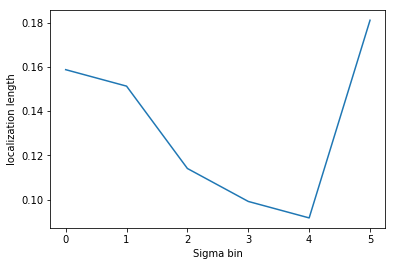

In [25]:
plt.figure()
plt.plot(opt_rho_array)
plt.xlabel('Sigma bin')
plt.ylabel('localization length')

Ens size: 60 

Ens of ens size: 10 

Current singular values: slice(0, 3, None) 

Minimize norm2 error: 0.1736 

Minimize average angle among ensembles: 0.1587 

Minimize average angle from truth: 0.1736 

Current singular values: slice(3, 5, None) 

Minimize norm2 error: 0.1662 

Minimize average angle among ensembles: 0.1513 

Minimize average angle from truth: 0.1587 

Current singular values: slice(5, 7, None) 

Minimize norm2 error: 0.2479 

Minimize average angle among ensembles: 0.1141 

Minimize average angle from truth: 0.1438 

Current singular values: slice(7, 9, None) 

Minimize norm2 error: 0.2703 

Minimize average angle among ensembles: 0.09923 

Minimize average angle from truth: 0.129 

Current singular values: slice(9, 11, None) 

Minimize norm2 error: 0.3 

Minimize average angle among ensembles: 0.09179 

Minimize average angle from truth: 0.3 

Current singular values: slice(11, 13, None) 

Minimize norm2 error: 0.3 

Minimize average angle among ensembles: 0.181 


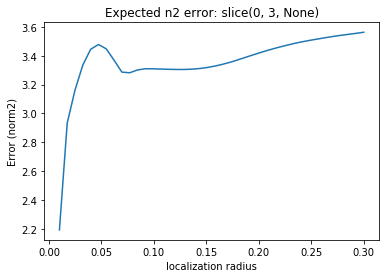

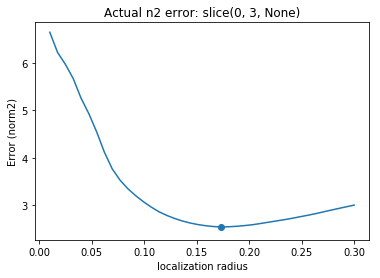

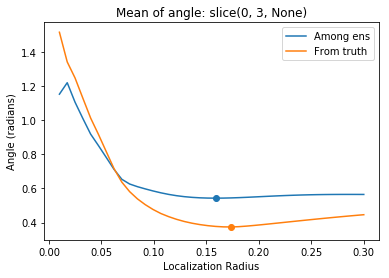

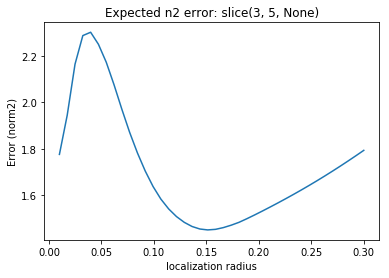

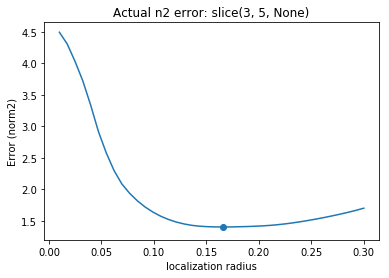

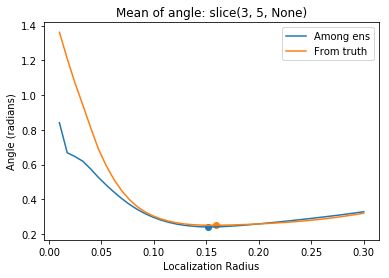

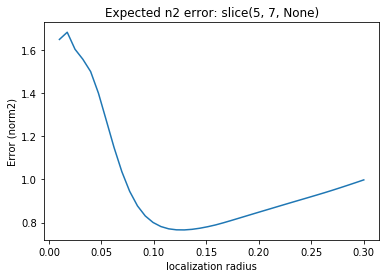

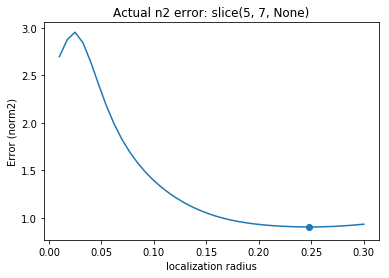

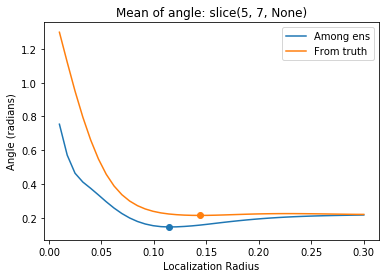

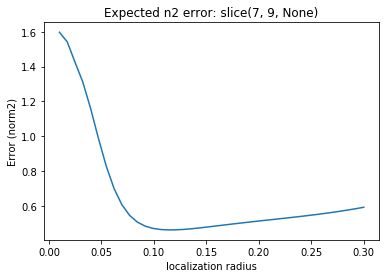

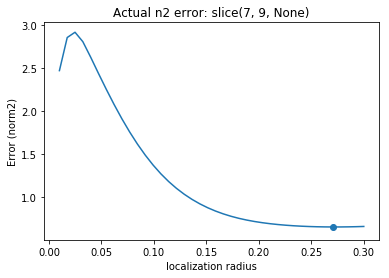

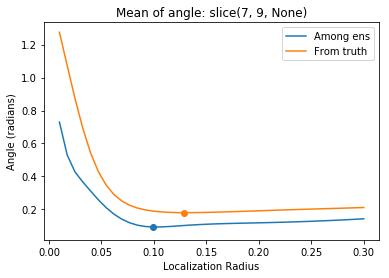

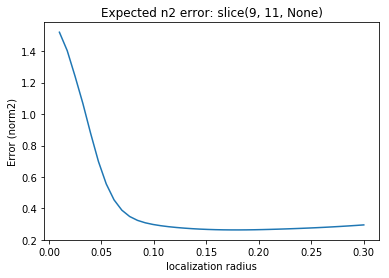

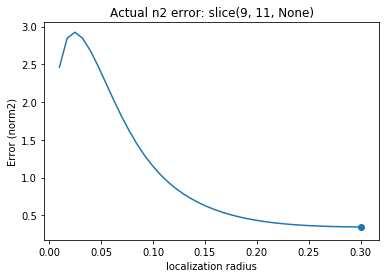

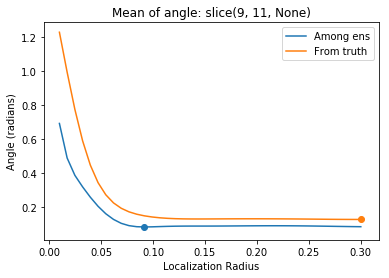

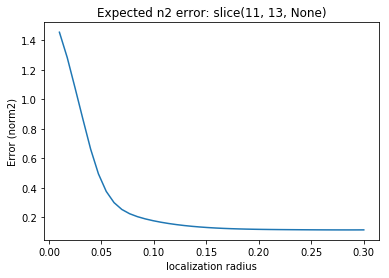

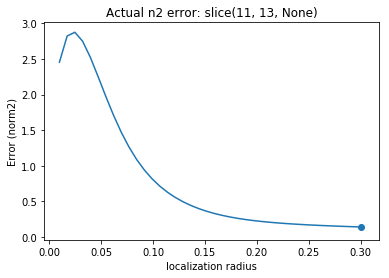

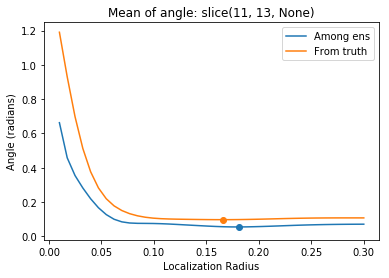

In [26]:
last_sig = 0
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    last_sig = last_sig + sig_num
    print(f'Current singular values: {sig_slice}', '\n')

    e2_arg = error_n2[sig_count].argmin()
    this_rho = rho_array[e2_arg]
    print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

    ea_arg = V_average_angle[sig_count].argmin()
    this_rho = rho_array[ea_arg]
    print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

    aa_arg = V_average_angle_2_truth[sig_count].argmin()
    this_rho = rho_array[aa_arg]
    print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')
    
    plt.figure()
    plt.plot(rho_array, exp_error_n2[sig_count])
    plt.title(f'Expected n2 error: {sig_slice}')
    plt.ylabel('Error (norm2)')
    plt.xlabel('localization radius')

    plt.figure()
    plt.plot(rho_array, error_n2[sig_count])
    plt.scatter(rho_array[e2_arg],
                error_n2[sig_count, e2_arg])
    plt.title(f'Actual n2 error: {sig_slice}')
    plt.ylabel('Error (norm2)')
    plt.xlabel('localization radius')


    plt.figure()
    plt.plot(rho_array, V_average_angle[sig_count])
    plt.plot(rho_array, V_average_angle_2_truth[sig_count])
    plt.scatter(rho_array[ea_arg],
                V_average_angle[sig_count, ea_arg])
    plt.scatter(rho_array[aa_arg],
                V_average_angle_2_truth[sig_count, aa_arg])
    plt.legend(['Among ens', 'From truth'])
    plt.xlabel('Localization Radius')
    plt.ylabel('Angle (radians)')
    plt.title(f'Mean of angle: {sig_slice}')

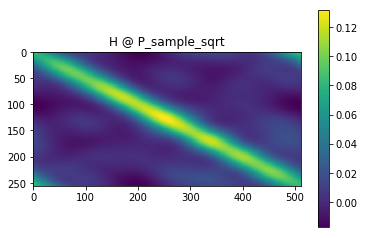

In [27]:
this_P_sqrt = covariance.matrix_sqrt(P_sample).real
imshow(H @ this_P_sqrt, 'H @ P_sample_sqrt')

# Using 'opt' singular values

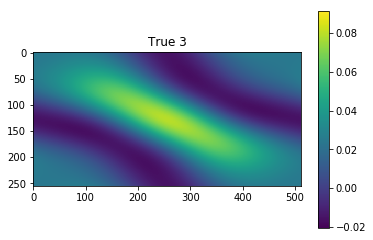

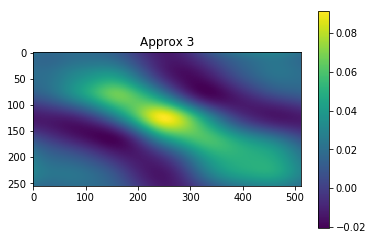

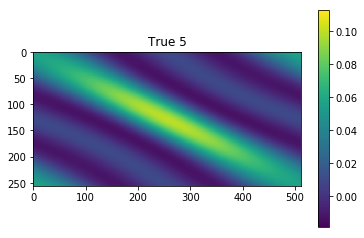

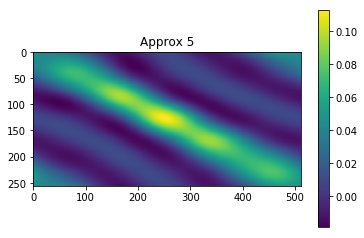

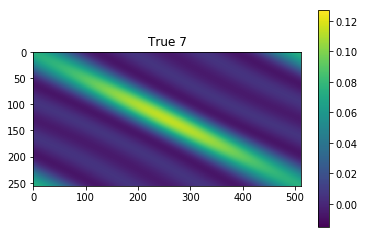

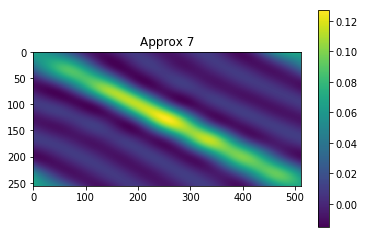

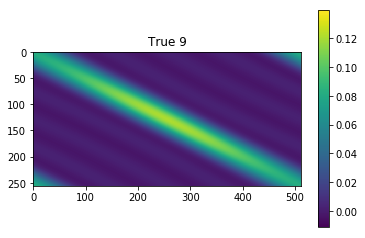

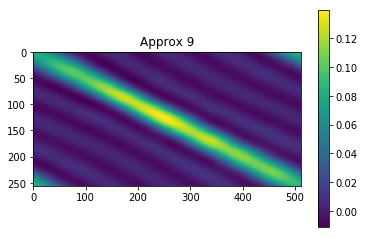

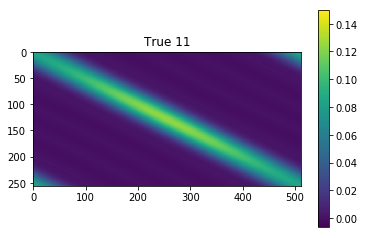

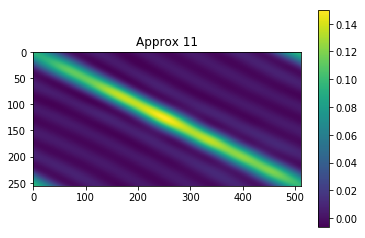

In [28]:
for this_sig in np.arange(3, total_sig, 2):
    real_recon = (U[:, :this_sig]
                  @ S[:this_sig, :this_sig]
                  @ VT[:this_sig])
    this_recon = (
        opt_U_array[:, :this_sig]
        @ np.diag(opt_s_array[:this_sig])
        @ opt_V_array[:, :this_sig].T)

#         this_recon = (
#             opt_U_array[:, :this_sig, ens_count]
#             @ S[:this_sig, :this_sig]
#             @ opt_V_array[:, :this_sig, ens_count].T)

    vmin = np.min([this_recon.min(), real_recon.min()])
    vmax = np.max([this_recon.max(), real_recon.max()])
    imshow(real_recon, vmin=vmin, vmax=vmax,
           title='True ' + str(this_sig))
    imshow(this_recon, vmin=vmin, vmax=vmax,
           title='Approx ' + str(this_sig))

# Using True singular values


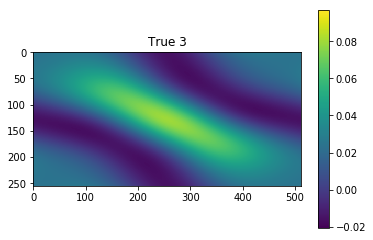

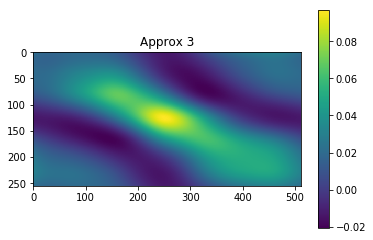

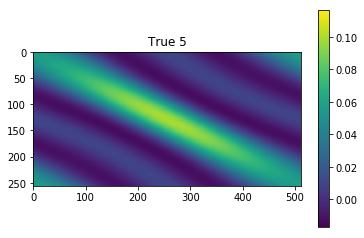

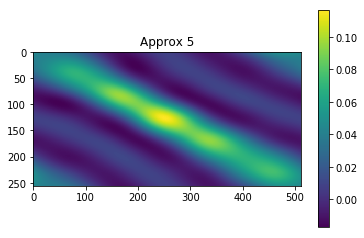

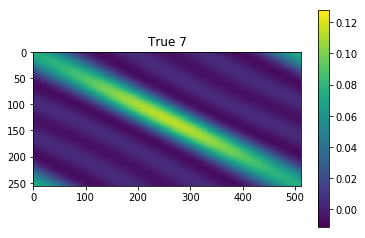

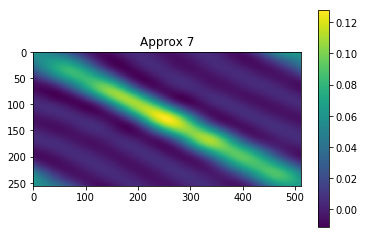

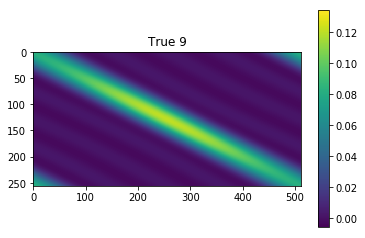

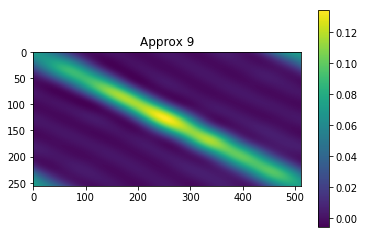

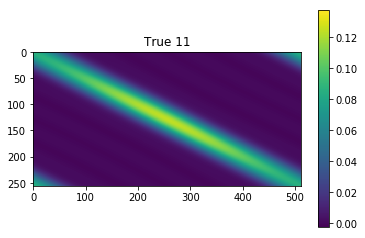

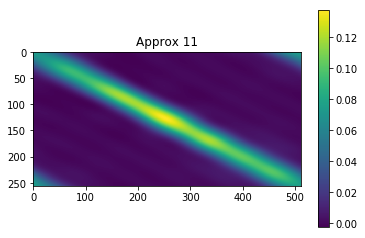

In [29]:
for this_sig in np.arange(3, total_sig, 2):
    real_recon = (U[:, :this_sig]
                  @ S[:this_sig, :this_sig]
                  @ VT[:this_sig])
        
    this_recon = (
        opt_U_array[:, :this_sig]
        @ S[:this_sig, :this_sig]
        @ opt_V_array[:, :this_sig].T)

    vmin = np.min([this_recon.min(), real_recon.min()])
    vmax = np.max([this_recon.max(), real_recon.max()])
    imshow(real_recon, vmin=vmin, vmax=vmax,
           title='True ' + str(this_sig))
    imshow(this_recon, vmin=vmin, vmax=vmax,
           title='Approx ' + str(this_sig))

In [30]:
sample_U_array = np.ones([obs_size, total_sig, ens_ens_size])
sample_s_array = np.ones([total_sig, ens_ens_size])
sample_V_array = np.ones([dimension, total_sig, ens_ens_size])
for ens_count in range(ens_ens_size):
    this_P = P_sample_array[:, :, ens_count]
    this_trans_mats = assimilate.transformation_matrices(
        H, P=this_P,
        R=R, return_Ts=True)

    aU = this_trans_mats['U']
    aS = this_trans_mats['S']
    aVT = this_trans_mats['VT']

    sample_U_array[:, :, ens_count] = aU[:, :total_sig]
    sample_s_array[:, ens_count] = aS.diagonal()[:total_sig]
    sample_V_array[:, :, ens_count] = aVT[:total_sig, :].T

# Using Sample singular values


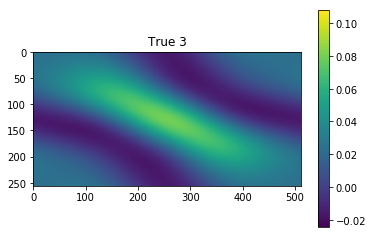

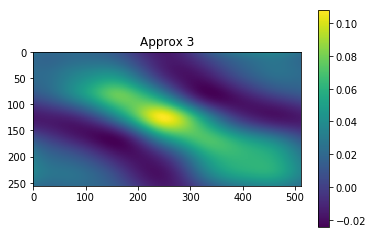

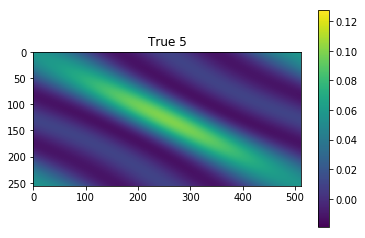

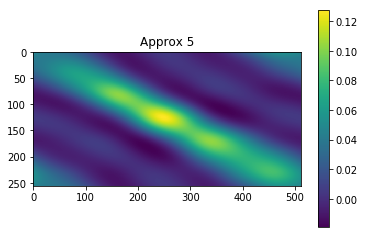

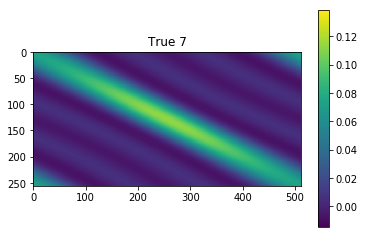

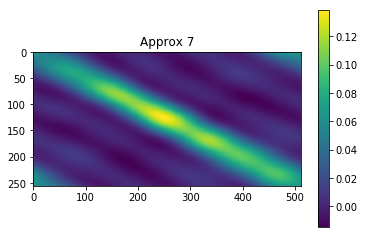

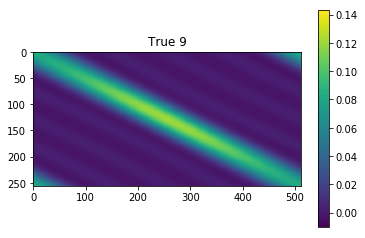

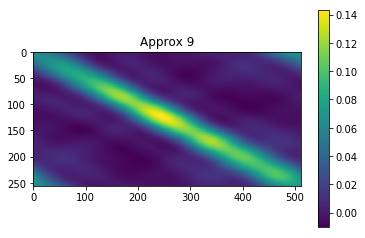

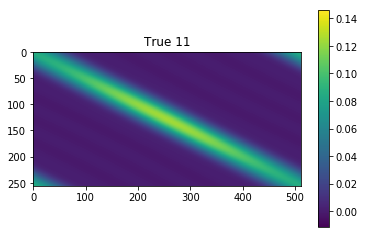

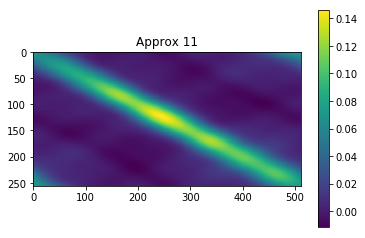

In [31]:
for this_sig in np.arange(3, total_sig, 2):
    real_recon = (U[:, :this_sig]
                  @ S[:this_sig, :this_sig]
                  @ VT[:this_sig]) 
    this_recon = (
        opt_U_array[:, :this_sig]
        @ np.diag(sample_s_array[:this_sig, 0])
        @ opt_V_array[:, :this_sig].T)

    vmin = np.min([this_recon.min(), real_recon.min()])
    vmax = np.max([this_recon.max(), real_recon.max()])
    imshow(real_recon, vmin=vmin, vmax=vmax,
           title='True ' + str(this_sig))
    imshow(this_recon, vmin=vmin, vmax=vmax,
           title='Approx ' + str(this_sig))

In [53]:
# plt.figure()
# plt.plot(S.diagonal()[:total_sig])
# plt.plot(sample_s_array[:total_sig], marker='.')
# plt.plot(opt_s_array[:total_sig])

# plt.figure()
# plt.semilogy(S.diagonal()[:total_sig])
# plt.semilogy(sample_s_array[:total_sig], marker='.')
# plt.semilogy(opt_s_array[:total_sig])

In [33]:
# sample_angle = np.ones(sig_bin_num) * np.nan
# last_sig = 0

# for sig_count, sig_num in enumerate(sig_array):
#     sig_slice = slice(last_sig, last_sig + sig_num)
#     last_sig = last_sig + sig_num
#     this_true_V = VT[sig_slice].T
#     angles = np.ones(ens_ens_size) * np.nan
#     for ens_count in range(ens_ens_size):
#         this_V = sample_V_array[:, sig_slice, ens_count]
#         angles[ens_count] = angle(this_V, this_true_V)
#     sample_angle[sig_count] = angles.mean()

In [34]:
trans_mats = assimilate.transformation_matrices(
    H, P=P_sample,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '_sample'+ '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


In [50]:
opt_V_array.shape

(512, 13)

In [51]:
sample_angle = np.ones(sig_bin_num) * np.nan
localized_angle = np.ones(sig_bin_num) * np.nan
last_sig = 0

for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    last_sig = last_sig + sig_num
    this_true_V = VT[sig_slice].T
    
    this_V = VT_sample[sig_slice].T
    sample_angle[sig_count] = angle(this_V, this_true_V)
    
    this_V = opt_V_array[:, sig_slice]
    localized_angle[sig_count] = angle(this_V, this_true_V)

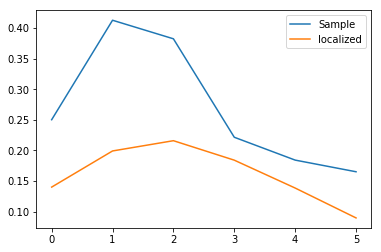

In [52]:
plt.figure()
plt.plot(sample_angle)

plt.plot(localized_angle)
plt.legend(['Sample',
            'localized'])

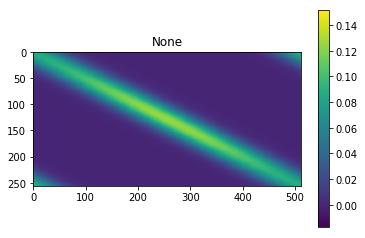

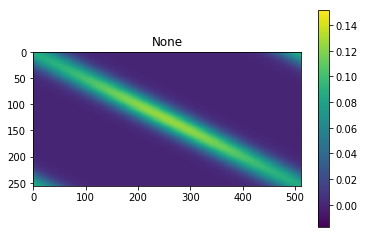

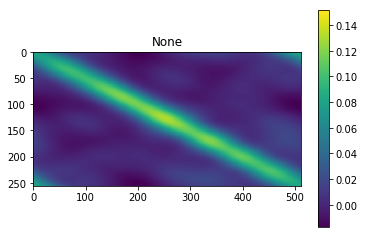

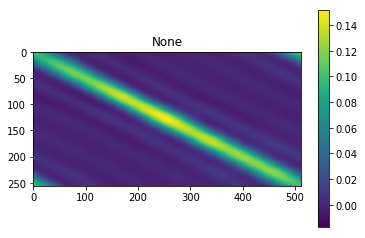

In [37]:
truth = H @ P_sqrt
true_reconstruct = (
    U[:, :total_sig]
    @ S[:total_sig, :total_sig]
    @ VT[:total_sig, :])
sample_reconstruct = (
    U_sample[:, :total_sig]
    @ S_sample[:total_sig, :total_sig]
    @ VT_sample[:total_sig, :])
# opt_reconstruct = (
#     opt_U_array[:, :total_sig]
#     @ S_sample[:total_sig, :total_sig]
#     @ opt_V_array[:, :total_sig].T)
opt_reconstruct = (
    opt_U_array[:, :total_sig]
    @ np.diag(opt_s_array[:total_sig])
    @ opt_V_array[:, :total_sig].T)
vmin = np.min([
    truth.min(),
    true_reconstruct.min(),
    sample_reconstruct.min(),
    opt_reconstruct.min()
])
vmax = np.max([
    truth.max(),
    true_reconstruct.max(),
    sample_reconstruct.max(),
    opt_reconstruct.max()
])
imshow(truth,
       vmin=vmin, vmax=vmax)
imshow(true_reconstruct,
       vmin=vmin, vmax=vmax)
imshow(sample_reconstruct,
       vmin=vmin, vmax=vmax)
imshow(opt_reconstruct,
       vmin=vmin, vmax=vmax)

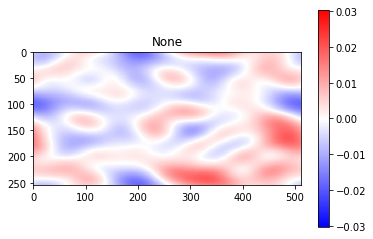

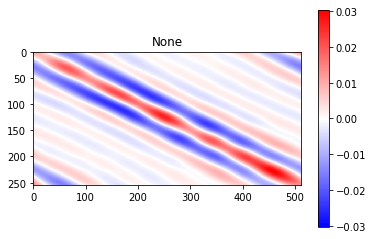

In [38]:
error_sample = (sample_reconstruct
                - true_reconstruct)
error_opt = (opt_reconstruct
             - true_reconstruct)
vmax = np.max([
    np.abs(error_sample).max(),
    np.abs(error_opt).max()
])

imshow(error_sample,
      vmax=vmax,
      vmin=-vmax,
      cmap='bwr')
imshow(error_opt,
      vmax=vmax,
      vmin=-vmax,
      cmap='bwr')

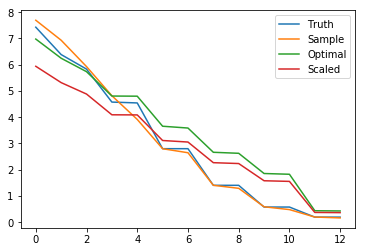

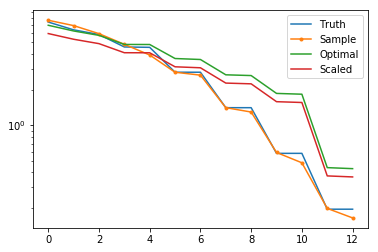

In [43]:
opt_sum = opt_s_array[:total_sig].sum()
sample_sum = S_sample.diagonal()[:total_sig].sum()
plt.figure()
plt.plot(S.diagonal()[:total_sig])
plt.plot(S_sample.diagonal()[:total_sig])
plt.plot(opt_s_array[:total_sig])
plt.plot(opt_s_array[:total_sig] * (sample_sum/opt_sum))
plt.legend([
    'Truth',
    'Sample',
    'Optimal',
    'Scaled'
])

plt.figure()
plt.semilogy(S.diagonal()[:total_sig])
plt.semilogy(S_sample.diagonal()[:total_sig], marker='.')
plt.semilogy(opt_s_array[:total_sig])
plt.semilogy(opt_s_array[:total_sig] * (sample_sum/opt_sum))
plt.legend([
    'Truth',
    'Sample',
    'Optimal',
    'Scaled'
])

Text(0,0.5,'Singular vector group')

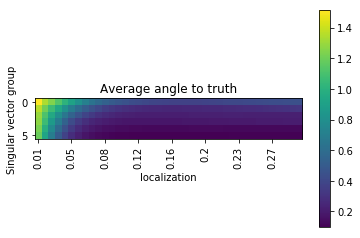

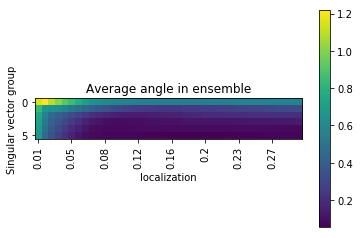

In [44]:
imshow(V_average_angle_2_truth,
       title='Average angle to truth')
plt.xticks(np.arange(rho_array.size)[::5],
           np.round(rho_array[::5], 2), rotation=90)
plt.xlabel('localization')
plt.ylabel('Singular vector group')

imshow(V_average_angle,
       title='Average angle in ensemble')
plt.xticks(np.arange(rho_array.size)[::5],
           np.round(rho_array[::5], 2), rotation=90)
plt.xlabel('localization')
plt.ylabel('Singular vector group')

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


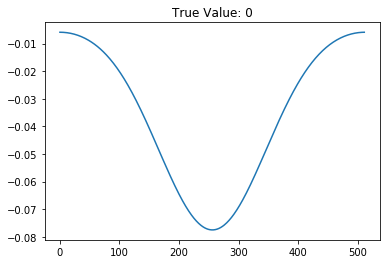

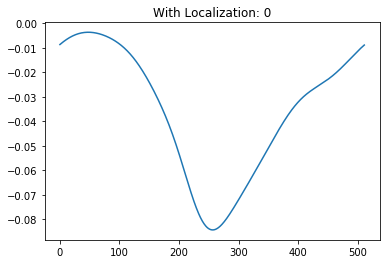

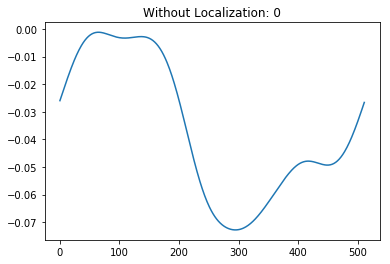

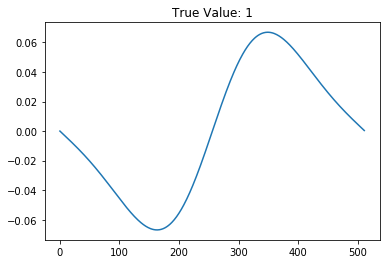

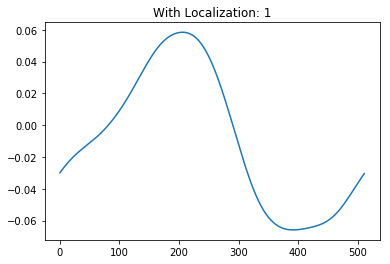

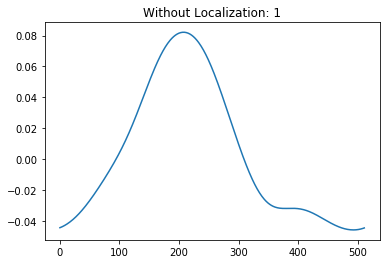

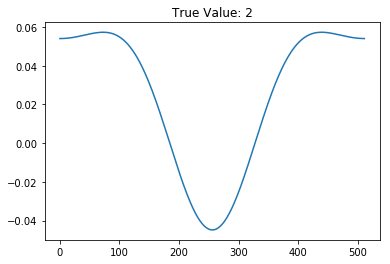

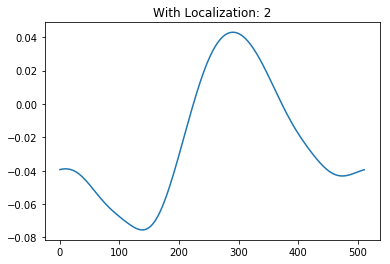

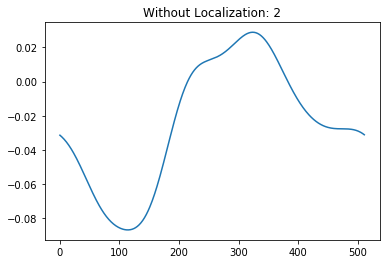

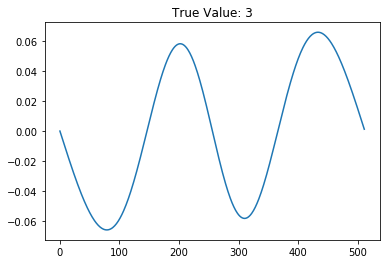

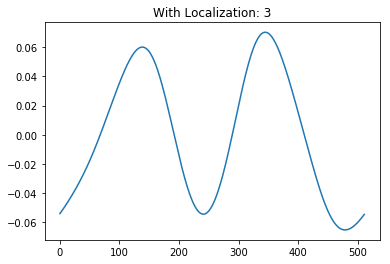

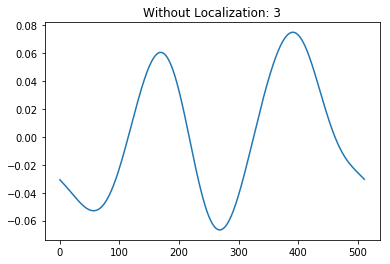

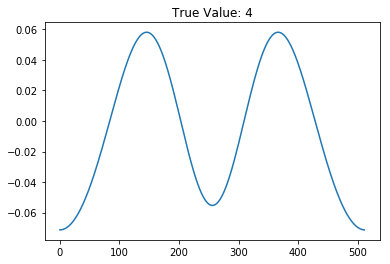

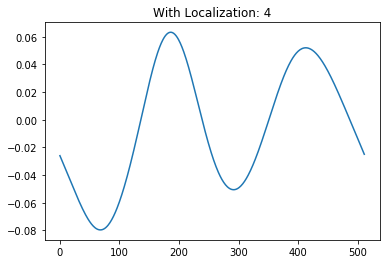

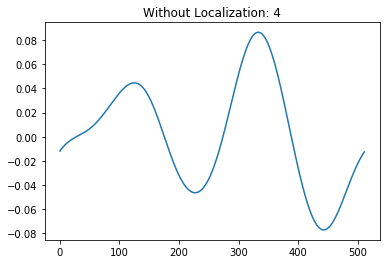

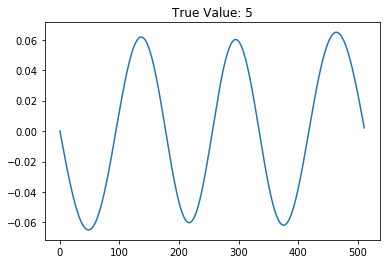

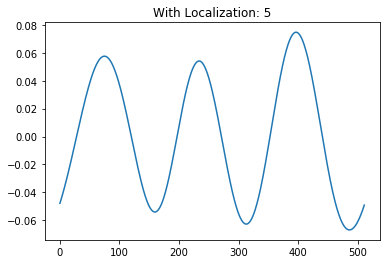

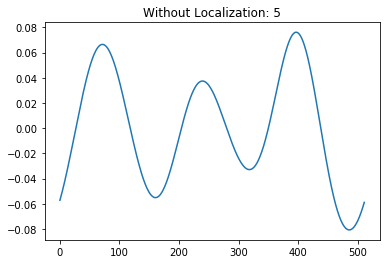

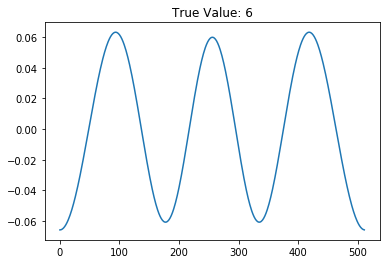

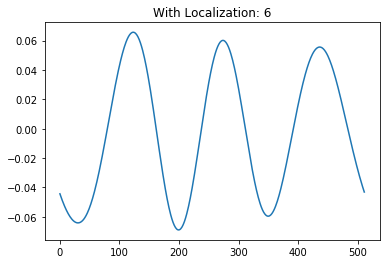

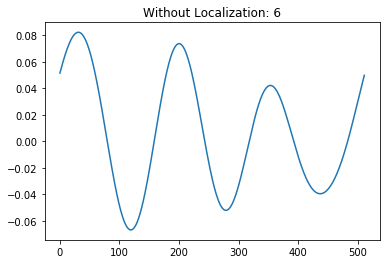

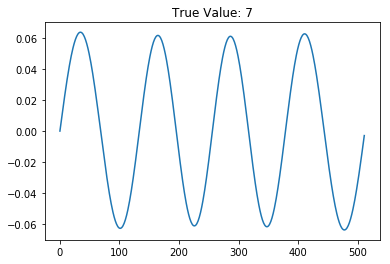

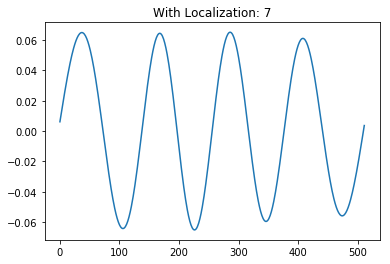

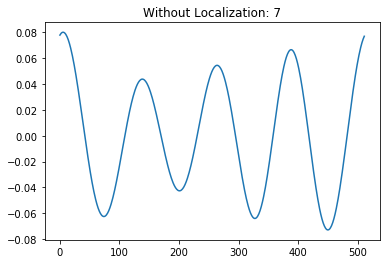

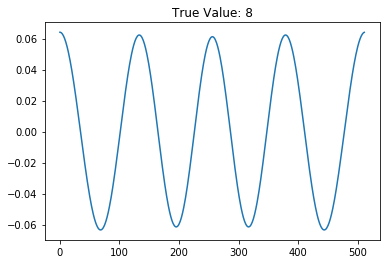

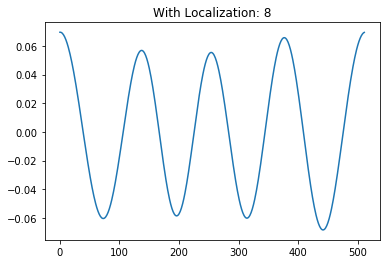

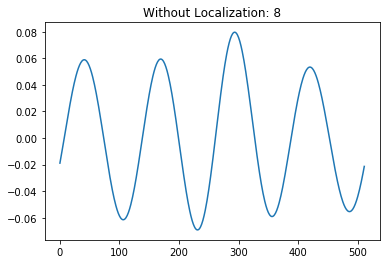

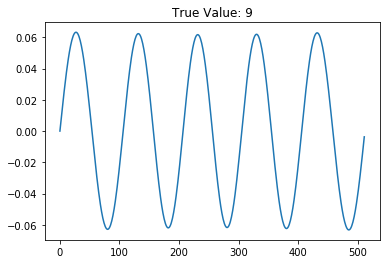

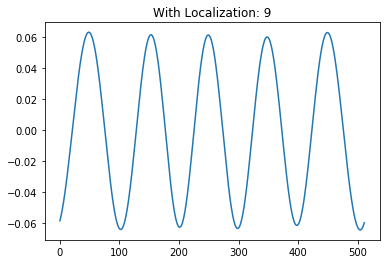

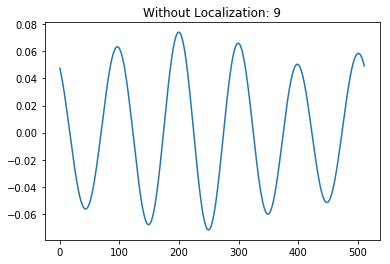

In [48]:
for this_sig in np.arange(10):
    plt.figure()
    plt.plot(VT[this_sig])
    plt.title(f'True Value: {this_sig}')
    
    plt.figure()
    plt.plot(opt_V_array[:, this_sig])
    plt.title(f'With Localization: {this_sig}')
    
    plt.figure()
    plt.plot(VT_sample[this_sig])
    plt.title(f'Without Localization: {this_sig}')
    
#     plt.figure()
#     plt.plot(sample_V_array[:, this_sig])
#     plt.title(f'Without Localization: {this_sig}')

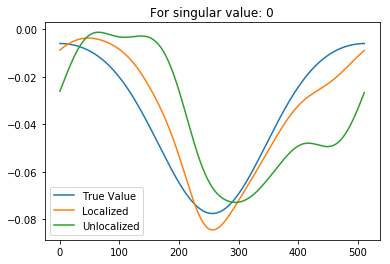

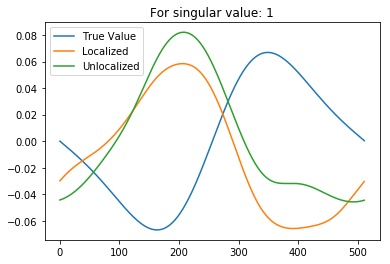

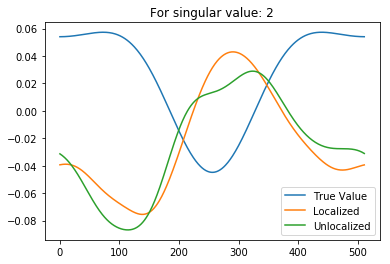

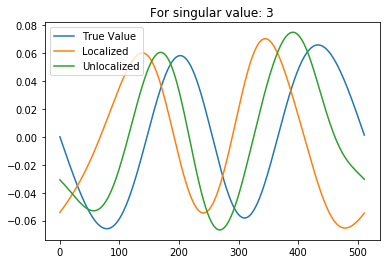

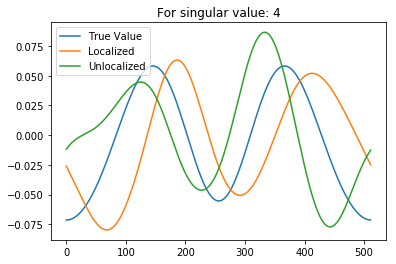

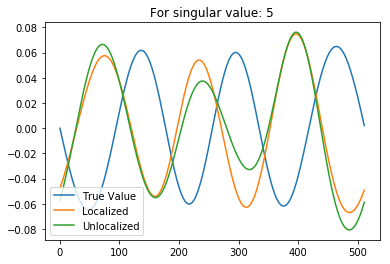

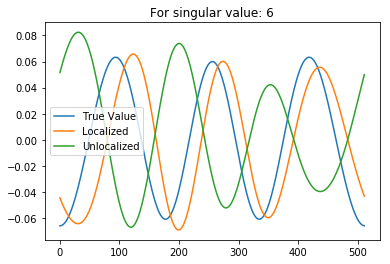

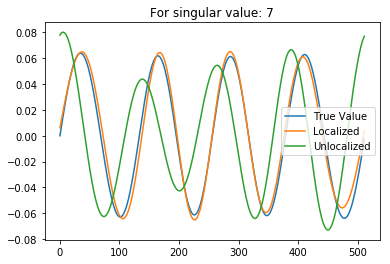

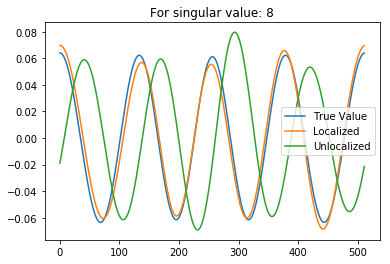

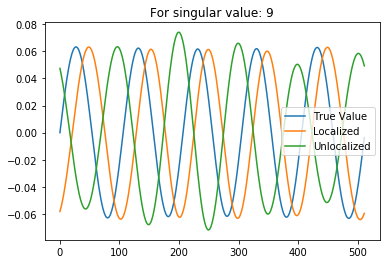

In [49]:
for this_sig in np.arange(10):
    plt.figure()
    plt.plot(VT[this_sig])
    plt.plot(opt_V_array[:, this_sig])    
    plt.plot(VT_sample[this_sig])
    plt.title(f'For singular value: {this_sig}')
    plt.legend(['True Value',
                'Localized',
                'Unlocalized'])

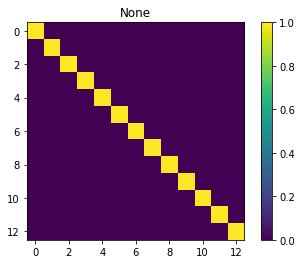

In [46]:
imshow(opt_V_array.T @ opt_V_array)

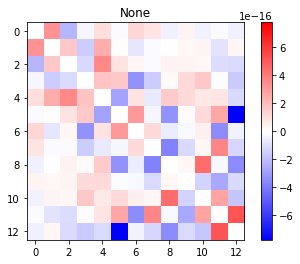

In [47]:
this = opt_V_array.T @ opt_V_array
indexes = np.diag_indices_from(this)
this[indexes] = 0
vmax = np.abs(this).max()
imshow(this, vmax=vmax, vmin=-vmax, cmap='bwr')